First, load the data,in this notebook we are using the PMI data from the paper:"Environmental predictors impact microbialbased postmortem interval (PMI) estimation models within human decomposition soils". The preprocessed data includes OTU/phylum/class/order abundance matrices (includes or not include environmental factors)

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric



2025-01-17 12:17:18.310464: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 12:17:18.313112: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-17 12:17:18.317283: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-17 12:17:18.328415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737134238.347409 2800741 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737134238.35

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import pickle
import matplotlib.pyplot as plt
import glob
import os

In [3]:
PMIdata_path = '../data/count_table/'

## No env model
16s (OTU/phylum/class/order) - no env

ITS (OTU/phylum/class/order) - no env

16s+ITS (OTU/phylum/class/order) - no env (only use this data when calculating H)
bact.ITS.n.class.env

### Data preprocess


In [4]:
bact_ITS_noenv_files = glob.glob(PMIdata_path + 'ITS.n.*.noenv.csv')


In [5]:
bact_ITS_noenv_files

['../data/count_table/ITS.n.class.noenv.csv',
 '../data/count_table/ITS.n.order.noenv.csv',
 '../data/count_table/ITS.n.phylum.noenv.csv',
 '../data/count_table/ITS.n.otu.noenv.csv']

In [6]:
# Read each CSV file into a list of dataframes
bact_ITS_noenv_df_list = [pd.read_csv(file) for file in bact_ITS_noenv_files]
taxlabels = ['class', 'order', 'phylum', 'otu']

In [7]:
for df in bact_ITS_noenv_df_list:
    print(df.shape)
    


(78, 67)
(78, 148)
(78, 17)
(78, 2220)


In [8]:
# target variable
y = bact_ITS_noenv_df_list[3].iloc[:, 0].values 

# Define the threshold
y_threshold = 2500

# Categorize the series based on the threshold
y = np.where(y > y_threshold, 'LONG', 'SHORT')

print(y)

print(list(y).count('LONG'))
print(list(y).count('SHORT'))

['SHORT' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'SHORT' 'SHORT'
 'SHORT' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG'
 'LONG' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT'
 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT'
 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG'
 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT'
 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT'
 'LONG' 'LONG' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'LONG'
 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG']
35
43


In [9]:
bact_ITS_noenv_df_list[3]

,ADH_10_actual,ITS00001,ITS00002,ITS00003,ITS00004,ITS00005,ITS00006,ITS00007,ITS00008,ITS00009,...,ITS03273,ITS03351,ITS03352,ITS03374,ITS03546,ITS03729,ITS03740,ITS03905,ITS03921,ITS04168
0,0.00000,1.048130,86.994801,1064.061714,302.490357,1.467382,633.909106,98.104981,105.441892,29.138018,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
1,1484.14700,0.977899,365.175603,1146.517281,587.019083,0.977899,1932.608756,63.703166,64.681065,16.763991,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
2,1989.56009,5.274172,170.474846,1438.828113,381.441720,0.850673,677.646018,155.843272,96.976709,1.190942,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
3,2973.68000,6.878189,68.781895,624.473042,1328.045263,1.996894,330.153095,145.662303,75.992900,4.881296,...,0.000000,0.000000,0.0,0.332816,0.0,0.000000,0.000000,0.0,0.0,0.0
4,4027.69203,3.817691,21.731470,403.500529,1420.768237,0.293669,408.786562,66.369083,44.343945,5.579702,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,4447.32241,488.558597,1634.516681,28.977759,254.491018,2082.335329,74.743370,120.722840,255.346450,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
74,0.00000,20.776236,25.196711,123.773318,124.657413,0.000000,880.116701,17.239855,29.617187,2.652285,...,9.725046,17.681903,0.0,15.913712,0.0,11.935284,9.282999,0.0,0.0,0.0
75,1477.74800,2933.290018,257.518774,163.807429,3074.106931,3.623505,801.794260,11.745155,126.197943,1.749278,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.374845,0.0,0.0,0.0
76,2554.43400,2782.890609,2565.572056,385.275047,245.764484,1.882451,453.252458,53.126961,119.012759,3.555741,...,0.418323,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0


In [10]:
df_list = []
col_names_4taxa=[]
for df in bact_ITS_noenv_df_list:
    data = df.drop(df.columns[0], axis=1)# delete the response column
    df_list.append(data)
    cols_name = df.columns
    col_names_4taxa.append(cols_name)

#### OTU

##### 1. calculate H statistics for OTU/phylum/class/order (both 16s and ITS)

['class', 'order', 'phylum', 'otu']


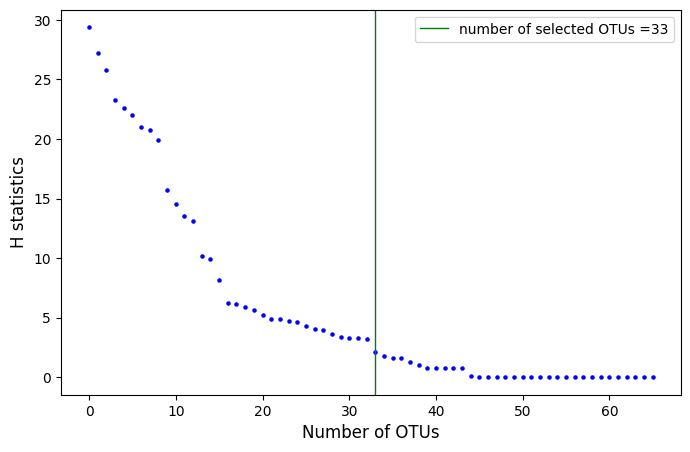

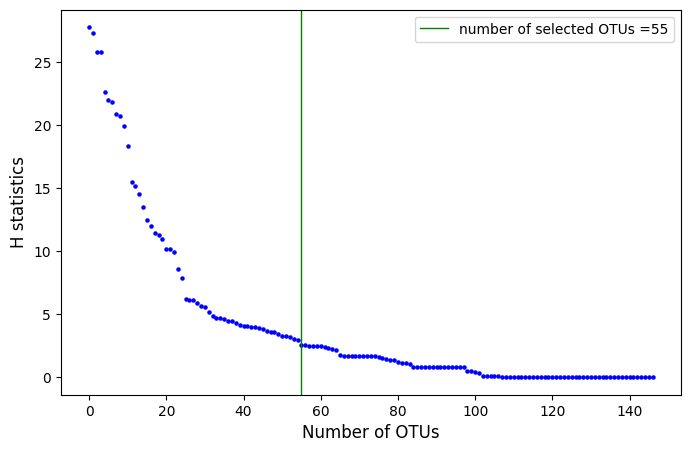

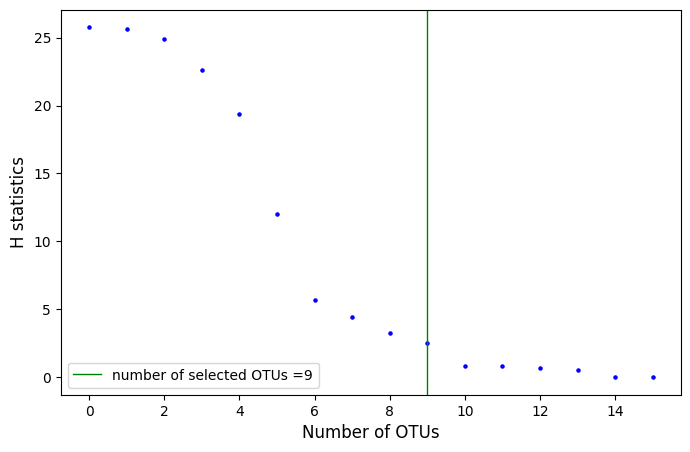

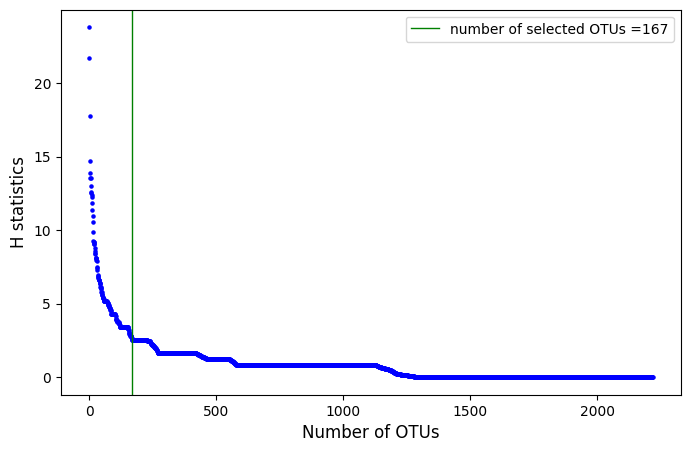

In [30]:
data_4taxa = []
weights_4taxa = []
selectedOTU_index_4tax = []
X_FS_4taxa = []
selectedASVs_4taxa = []
eps_4tax = []
print(taxlabels)
for df in df_list:
    select_result = FS.SelectMicro_fun(df,y,threshold=0.001)
    data_4taxa.append(select_result['relative_abundance_data'])
    weights_4taxa.append(select_result['H_score'])
    selectedOTU_index_4tax.append(select_result['selected_indices'])
    X_FS_4taxa.append(select_result['selected_data'])
    selectedASVs_4taxa.append(select_result['selected_columnames'])
    eps = len(select_result['selected_indices'])
    eps_4tax.append(eps)

In [12]:
print(eps_4tax)

[33, 55, 9, 167]


In [13]:
for weight in weights_4taxa:
    print(len(weight))

66
147
16
2219


In [14]:
max(weights_4taxa[3])

23.791295517208443

In [15]:
len(selectedOTU_index_4tax)

4

In [16]:
for i in range(4):
    print(f"Selected features in {taxlabels[i]} : {selectedASVs_4taxa[i]}")

Selected features in class : Index(['c__Dothideomycetes', 'c__Saccharomycetes', 'c__unclassified_Fungi',
       'c__Agaricomycetes', 'k__Fungi_unclassified', 'c__Rhizophydiomycetes',
       'c__Glomeromycetes', 'c__unclassified_Rozellomycota',
       'p__Ascomycota_unclassified', 'c__Orbiliomycetes',
       'p__Chytridiomycota_unclassified', 'c__unclassified_Glomeromycota',
       'c__Rozellomycotina_cls_Incertae_sedis',
       'p__Glomeromycota_unclassified', 'p__Basidiomycota_unclassified',
       'c__Cystobasidiomycetes', 'c__unclassified_Chytridiomycota',
       'c__Paraglomeromycetes', 'c__Laboulbeniomycetes',
       'c__Sanchytriomycetes', 'c__Spizellomycetes', 'c__Eurotiomycetes',
       'p__Rozellomycota_unclassified', 'c__Lobulomycetes',
       'c__Tremellomycetes', 'c__Exobasidiomycetes', 'c__Atractiellomycetes',
       'p__Mortierellomycota_unclassified', 'c__Zoopagomycetes',
       'c__Sordariomycetes', 'c__Pezizomycetes', 'c__Leotiomycetes',
       'c__Mortierellomycetes']

##### 2. Select indices of the features based on H statistics and form the subset based on the selected features.
The default p value of the function is 10%, the resulted index is ranked by its H statistics descendingly.

Use "indice_H_unisig" if there is only one response, use "indice_H_multisig" for multiple responses.

weights_4taxa,selectedOTU_index_4tax,col_names_4taxa,eps_4tax

In [17]:
#plot the h statistics and cutoff descendingly
#for i in range(len(weights_4taxa)):
    #FS.plotWeightedIndex(weights_4taxa[i],threshold=eps_4tax[i])

#### 4. Model
Prepare 4 datasets: full dataset, our selected dataset, Lasso selected  dataset(based on the target variable), randomly selected data (selected the same numer of variables as in our method)

Use random forest and SVM as classifier, and will build both models for each response variable.

For Lasso, the dataset will be determined by the response variable, so the lasso subset is different for the models for different response variables.

For random selection, the  process will repeat iter=30 times to  find the mean accuracy and AUC

SMOTE  is used (the data is not balanced, as we can see the performance is really bad especially for SVM model when not using SMOTE)

In [18]:
iter =30
cls = ["RF","SVM", "CatBoost","NB"]

In [19]:
targetLabel=y

In [20]:
data_subset_4taxa = []
X_lasso_4taxa = []
X_lasso_ft_4taxa = []
xind_lasso_4taxa = []
xind_lasso_ft_4taxa = []
for i, data  in enumerate(data_4taxa):
    X_lasso,xind_lasso = RunML_continue.LassoFeatureSelection(data,targetLabel)
    X_lasso_ft,xind_lasso_ft = RunML_continue.LassoFS_CV(data,targetLabel)
    X_lasso_4taxa.append(X_lasso)
    X_lasso_ft_4taxa.append(X_lasso_ft)
    xind_lasso_4taxa.append(xind_lasso)
    xind_lasso_ft_4taxa.append(xind_lasso_ft)
    data_subset = {"AllFeatures":data, 
                "SelectMicro": X_FS_4taxa[i],
                "Lasso":X_lasso,
                "Lasso_finetune":X_lasso_ft
              }
    data_subset_4taxa.append(data_subset)

Best alpha: 0.05
Best alpha: 0.1
Best alpha: 0.05
Best alpha: 0.1


In [21]:
for i, dataset  in enumerate(data_subset_4taxa):
    data_subset = dataset
    print(taxlabels[i])
    for datatype, subset in data_subset.items():
        print(np.shape(subset))

class
(78, 66)
(78, 33)
(78, 15)
(78, 15)
order
(78, 147)
(78, 55)
(78, 21)
(78, 10)
phylum
(78, 16)
(78, 9)
(78, 5)
(78, 5)
otu
(78, 2219)
(78, 167)
(78, 43)
(78, 14)


In [22]:
with open('../data/data_subset_4taxa_paperthreshold_its.pkl', 'wb') as file:
    pickle.dump(data_subset_4taxa, file)

In [23]:
X_FS_lasso_4taxa = []
selectedOTU_index_FS_lasso_4taxa = []
X_FS_lassoft_4taxa = []
selectedOTU_index_FS_lassoft_4taxa = []

data_FS_lasso_4taxa = []

for i, data  in enumerate(data_4taxa):
    print(taxlabels[i])
        
    X_FS = X_FS_4taxa[i]
    
    X_FS_lasso,xlabel_FS_lasso = RunML_continue.LassoFeatureSelection(X_FS,targetLabel)# this is depend on the target variable(do not update here)
    X_FS_lasso_4taxa.append(X_FS_lasso)
    selectedOTU_index_FS_lasso_4taxa.append(np.array(selectedOTU_index_4tax[i])[xlabel_FS_lasso])

    X_FS_lasso_ft,xlabel_FS_lasso_ft  = RunML_continue.LassoFS_CV(X_FS,targetLabel)
    X_FS_lassoft_4taxa.append(X_FS_lasso_ft)
    selectedOTU_index_FS_lassoft_4taxa.append(np.array(selectedOTU_index_4tax[i])[xlabel_FS_lasso_ft])
    
    
    data_subset = {"FS_Lasso":X_FS_lasso,
                "FS_Lassofinetune":X_FS_lasso_ft}

    data_FS_lasso_4taxa.append(data_subset)
    
    print(f'The shape of the FS_Lasso selected dataset is ',np.shape(X_FS_lasso))
    print(f'The shape of the FS_Lasso_finetune selected dataset is ',np.shape(X_FS_lasso_ft))


class
Best alpha: 0.05
The shape of the FS_Lasso selected dataset is  (78, 16)
The shape of the FS_Lasso_finetune selected dataset is  (78, 16)
order
Best alpha: 0.05
The shape of the FS_Lasso selected dataset is  (78, 18)
The shape of the FS_Lasso_finetune selected dataset is  (78, 18)
phylum
Best alpha: 0.05
The shape of the FS_Lasso selected dataset is  (78, 5)
The shape of the FS_Lasso_finetune selected dataset is  (78, 5)
otu
Best alpha: 0.05
The shape of the FS_Lasso selected dataset is  (78, 35)
The shape of the FS_Lasso_finetune selected dataset is  (78, 35)


In [24]:
with open('../data/data_FS_lasso_4taxa_paperthreshold_its.pkl', 'wb') as file:
    pickle.dump(data_FS_lasso_4taxa, file)

In [25]:
#with open('../data/data_AE_4taxa.pkl', 'wb') as file:
#    pickle.dump(data_AE_4taxa, file)

### Fisher_discriminant_ratio

The Fisher Discriminant Ratio is a measure used in statistics and machine learning to evaluate the separability between two or more classes. It is commonly used in Linear Discriminant Analysis (LDA) to reduce dimensionality while preserving as much of the class discriminatory information as possible.

Fisher's Criterion / Fisher's Discriminant Ratio
Fisher's discriminant ratio evaluates how well the classes can be separated based on the ratio of the between-class scatter matrix to the within-class scatter matrix.

In [26]:
for i in range(len(taxlabels)):
    print(f"Analysis of {taxlabels[i]}")
    for datatype, subset in data_subset_4taxa[i].items():
        print(f"f1 of {datatype} = {metric.fisher_discriminant_ratio(subset,targetLabel)}")
    for datatype, subset in data_FS_lasso_4taxa[i].items():
        print(f"f1 of {datatype} = {metric.fisher_discriminant_ratio(subset,targetLabel)}")


Analysis of class
f1 of AllFeatures = 0.27122291848216906
f1 of SelectMicro = 0.27325942863667124
f1 of Lasso = 0.3626114645896617
f1 of Lasso_finetune = 0.3626114645896617
f1 of FS_Lasso = 0.34219519008612614
f1 of FS_Lassofinetune = 0.34219519008612614
Analysis of order
f1 of AllFeatures = 0.2607053990297547
f1 of SelectMicro = 0.30905209486008145
f1 of Lasso = 0.37731632093460976
f1 of Lasso_finetune = 0.3959844340429374
f1 of FS_Lasso = 0.3777748084041088
f1 of FS_Lassofinetune = 0.3777748084041088
Analysis of phylum
f1 of AllFeatures = 0.15916238455998155
f1 of SelectMicro = 0.1970291995574537
f1 of Lasso = 0.06228131824612096
f1 of Lasso_finetune = 0.06228131824612096
f1 of FS_Lasso = 0.18293716254412168
f1 of FS_Lassofinetune = 0.18293716254412168
Analysis of otu
f1 of AllFeatures = 0.11745050101484615
f1 of SelectMicro = 0.1735082725124418
f1 of Lasso = 0.21286858793955263
f1 of Lasso_finetune = 0.3496695069028723
f1 of FS_Lasso = 0.23557689946052737
f1 of FS_Lassofinetune = 0.

### compare the first 15 index by their present ratio

Index(['c__Dothideomycetes', 'c__Saccharomycetes', 'c__unclassified_Fungi',
       'c__Agaricomycetes', 'k__Fungi_unclassified', 'c__Rhizophydiomycetes',
       'c__Glomeromycetes', 'c__unclassified_Rozellomycota',
       'p__Ascomycota_unclassified', 'c__Orbiliomycetes',
       'p__Chytridiomycota_unclassified', 'c__unclassified_Glomeromycota',
       'c__Rozellomycotina_cls_Incertae_sedis',
       'p__Glomeromycota_unclassified', 'p__Basidiomycota_unclassified'],
      dtype='object')
(78, 15)
Validation passed: Dimensions are correct.
Long= 35, short = 43
                                      OTU  presence_pos  presence_neg
0                      c__Dothideomycetes      0.514286      0.906977
1                      c__Saccharomycetes      0.971429      0.697674
2                   c__unclassified_Fungi      0.085714      0.488372
3                       c__Agaricomycetes      0.514286      0.906977
4                   k__Fungi_unclassified      0.857143      0.976744
5              

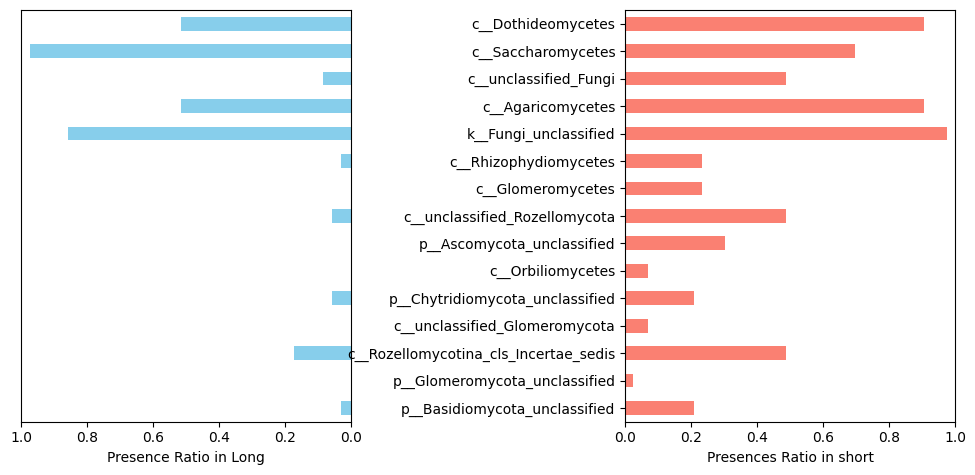

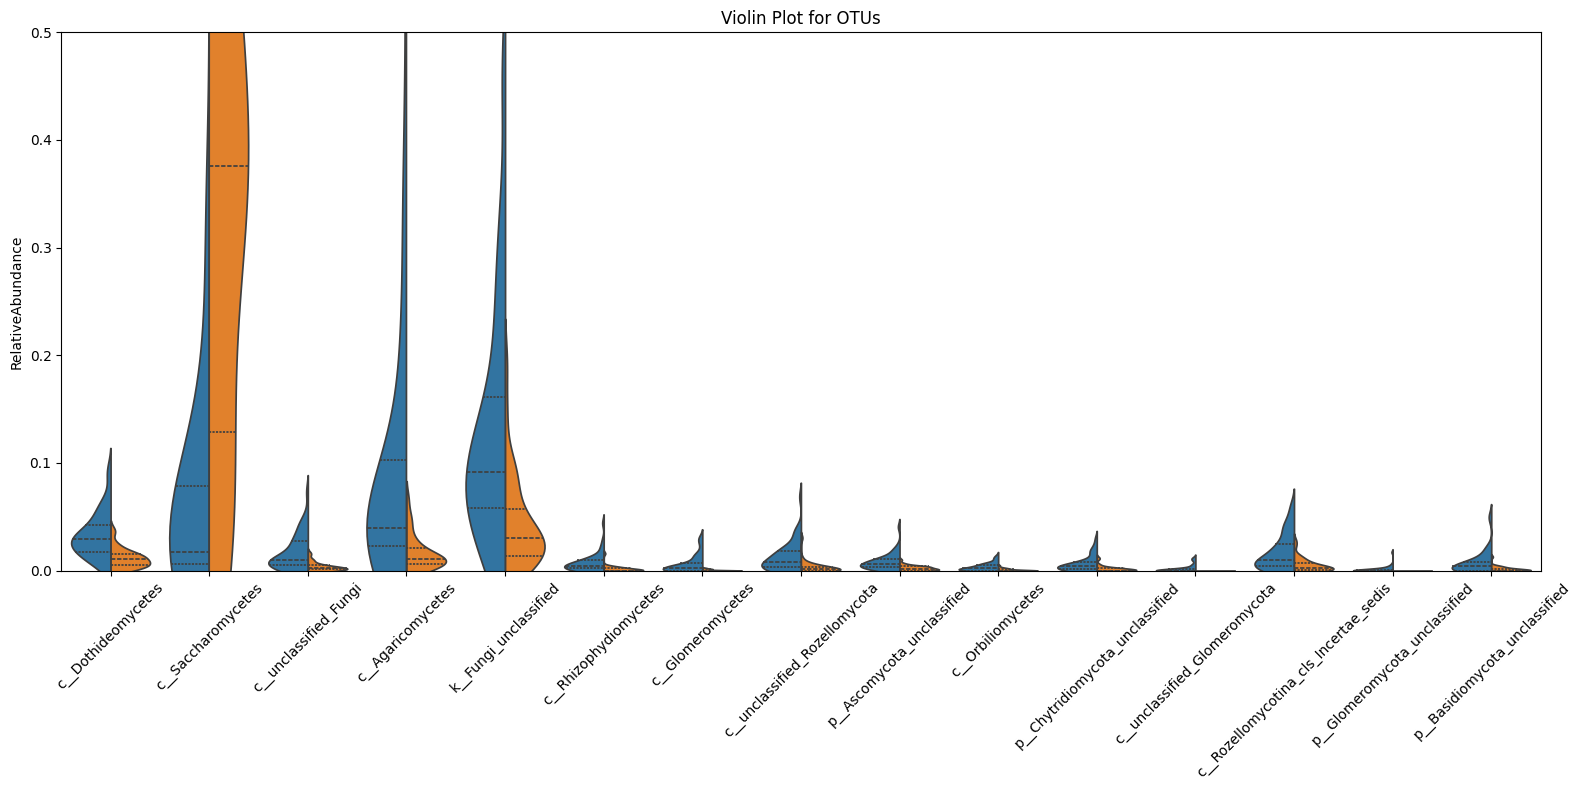

Index(['o__Pleosporales', 'o__Saccharomycetales', 'o__Capnodiales',
       'o__unclassified_Fungi', 'k__Fungi_unclassified', 'o__Rhizophydiales',
       'o__Glomerales', 'o__Agaricales', 'o__unclassified_Rozellomycota',
       'p__Ascomycota_unclassified', 'o__Auriculariales', 'o__Helotiales',
       'c__Sordariomycetes_unclassified', 'p__Chytridiomycota_unclassified',
       'o__unclassified_Glomeromycota'],
      dtype='object')
(78, 15)
Validation passed: Dimensions are correct.
Long= 35, short = 43
                                OTU  presence_pos  presence_neg
0                   o__Pleosporales      0.200000      0.790698
1              o__Saccharomycetales      0.971429      0.697674
2                    o__Capnodiales      0.000000      0.139535
3             o__unclassified_Fungi      0.085714      0.488372
4             k__Fungi_unclassified      0.857143      0.976744
5                 o__Rhizophydiales      0.028571      0.232558
6                     o__Glomerales      0.0

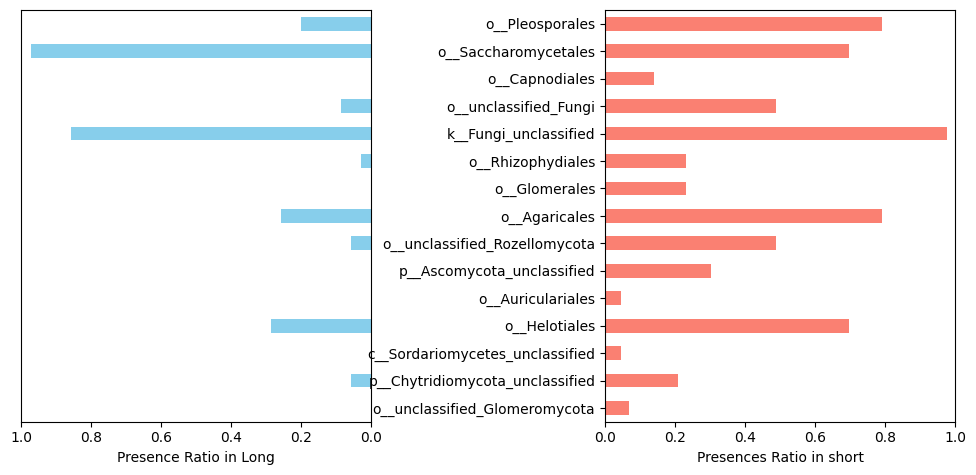

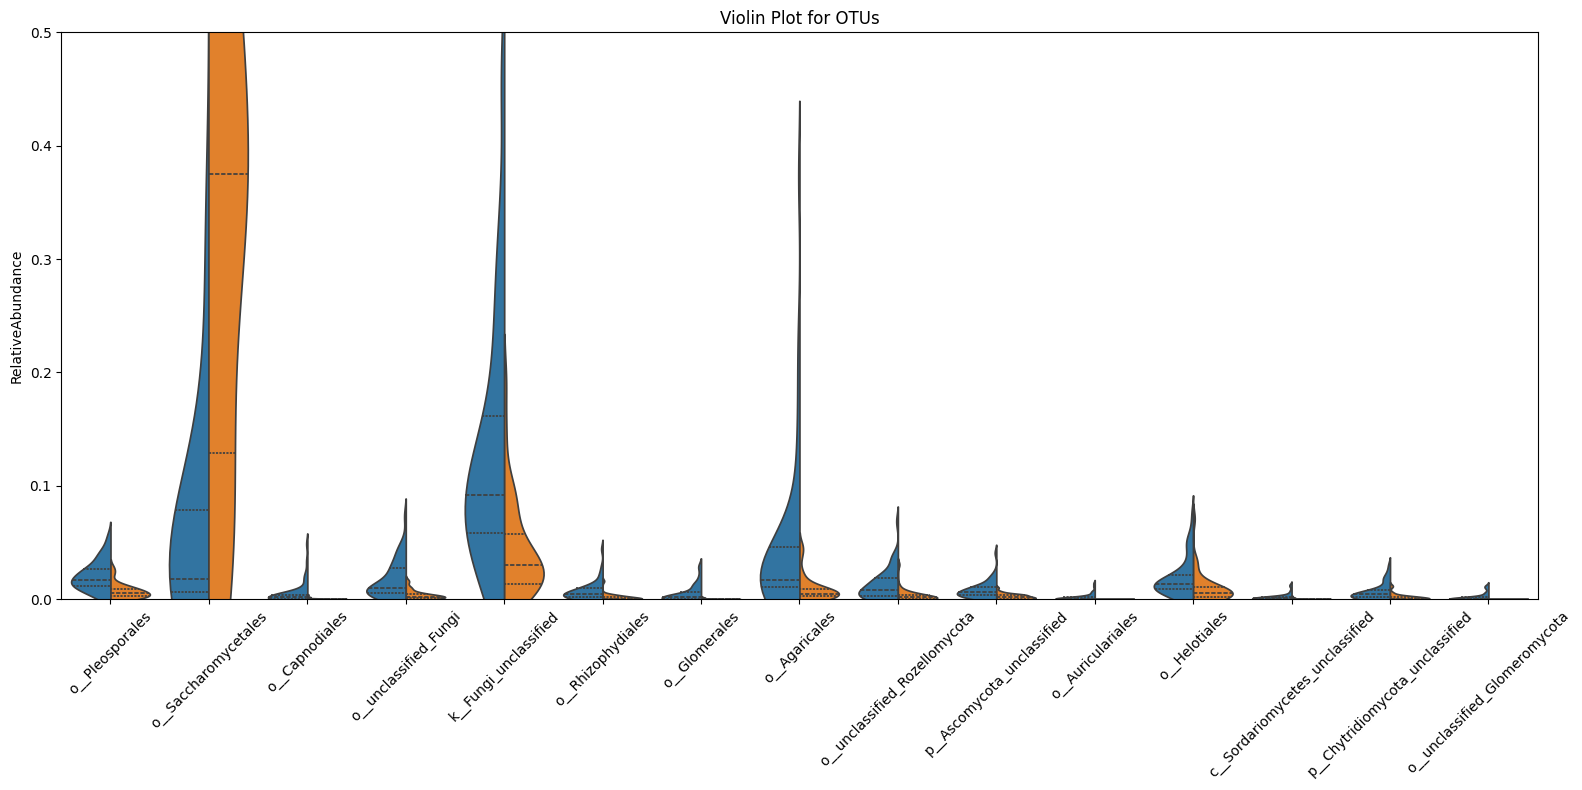

Index(['p__unclassified_Fungi', 'p__Glomeromycota', 'p__Chytridiomycota',
       'k__Fungi_unclassified', 'p__Rozellomycota', 'p__Ascomycota',
       'p__Monoblepharomycota', 'p__Zoopagomycota', 'p__Mortierellomycota'],
      dtype='object')
(78, 9)
Validation passed: Dimensions are correct.
Long= 35, short = 43
                     OTU  presence_pos  presence_neg
0  p__unclassified_Fungi      0.085714      0.488372
1       p__Glomeromycota      0.000000      0.255814
2     p__Chytridiomycota      0.114286      0.534884
3  k__Fungi_unclassified      0.857143      0.976744
4       p__Rozellomycota      0.371429      0.837209
5          p__Ascomycota      1.000000      1.000000
6  p__Monoblepharomycota      0.000000      0.023256
7       p__Zoopagomycota      0.000000      0.000000
8   p__Mortierellomycota      0.942857      0.976744


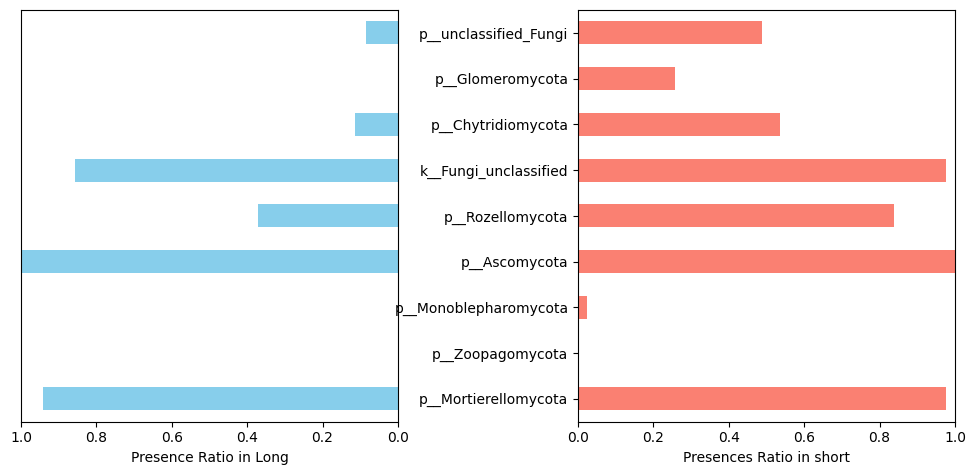

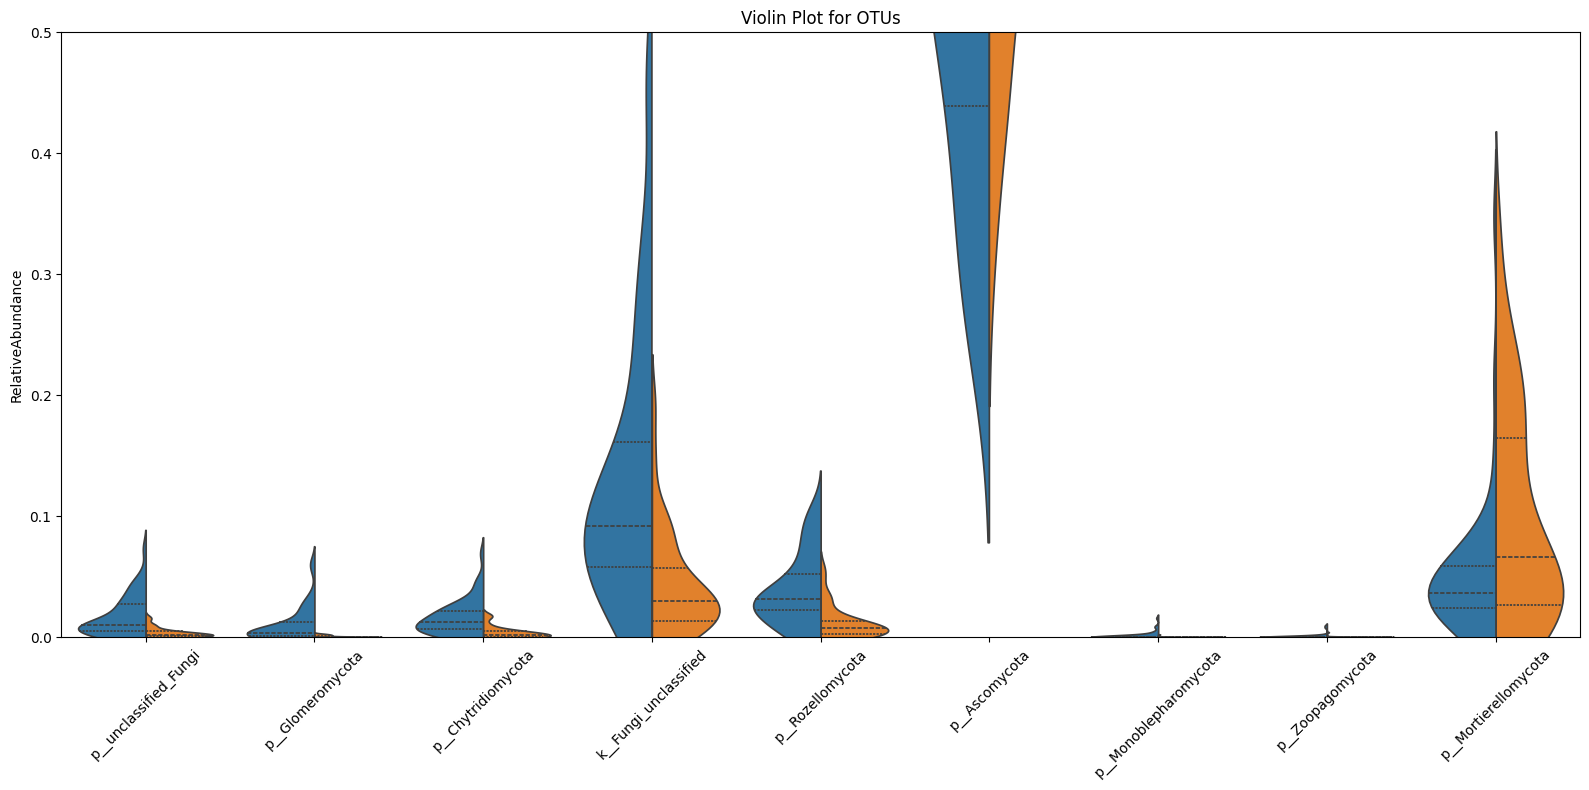

Index(['ITS00002', 'ITS00001', 'ITS00006', 'ITS00190', 'ITS00098', 'ITS00138',
       'ITS00270', 'ITS00012', 'ITS00030', 'ITS00050', 'ITS00166', 'ITS00056',
       'ITS00008', 'ITS00156', 'ITS00182'],
      dtype='object')
(78, 15)
Validation passed: Dimensions are correct.
Long= 35, short = 43
         OTU  presence_pos  presence_neg
0   ITS00002      0.857143      0.441860
1   ITS00001      0.828571      0.302326
2   ITS00006      0.485714      0.790698
3   ITS00190      0.000000      0.046512
4   ITS00098      0.000000      0.046512
5   ITS00138      0.000000      0.069767
6   ITS00270      0.000000      0.000000
7   ITS00012      0.142857      0.465116
8   ITS00030      0.028571      0.209302
9   ITS00050      0.000000      0.116279
10  ITS00166      0.000000      0.000000
11  ITS00056      0.000000      0.069767
12  ITS00008      0.657143      0.372093
13  ITS00156      0.000000      0.023256
14  ITS00182      0.000000      0.023256


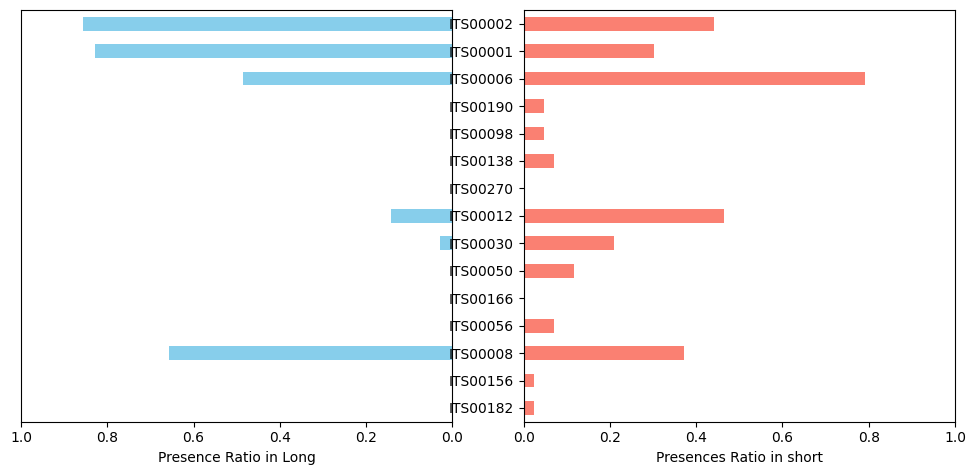

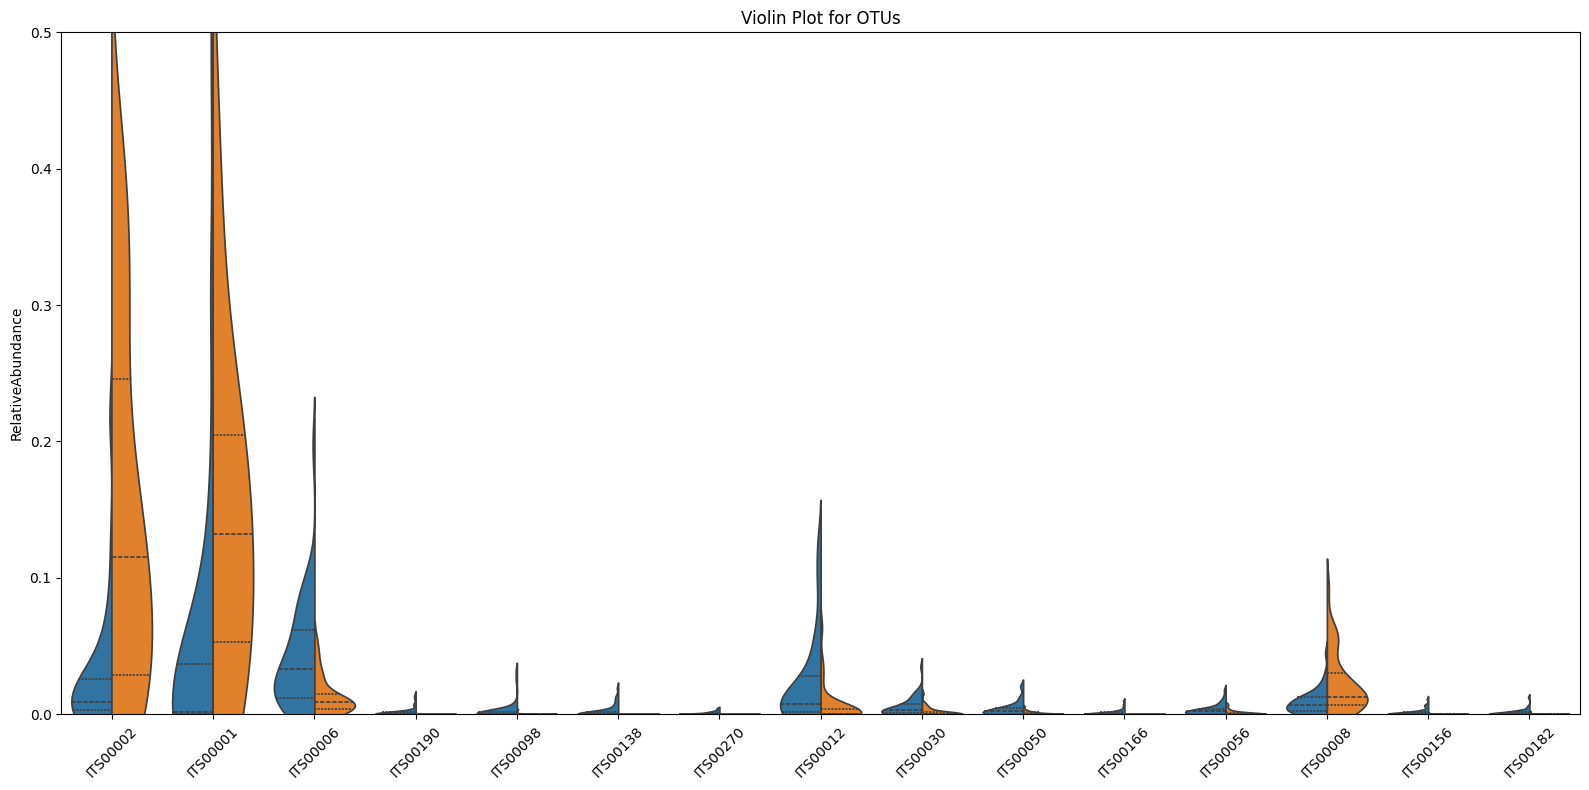

In [27]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

entries=15

for i, data_FS in enumerate(X_FS_4taxa):
    selectedASVs_15=selectedASVs_4taxa[i][:entries]
    print(selectedASVs_15)
    X_FS_15=data_FS[:,:entries]
    print(X_FS_15.shape)
    #df=pd.DataFrame(data=X_FS_15)
    FS.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs_15,posLabel="LONG",posText="Long",negText="short")
    FS.OTUviolin(X_FS_15,targetLabel,selectedASVs_15,y_max=0.5)

Fine tuned Lasso selected Index(['ADH_10_actual', 'c__Eurotiomycetes', 'c__Mortierellomycetes',
       'c__Atractiellomycetes', 'c__Microbotryomycetes',
       'p__Rozellomycota_unclassified', 'c__Rhizophydiomycetes',
       'c__unclassified_Rozellomycota', 'c__Mucoromycetes',
       'c__unclassified_Mortierellomycota', 'c__Glomeromycetes',
       'c__Sanchytriomycetes', 'c__unclassified_Fungi',
       'c__Archaeorhizomycetes', 'c__Orbiliomycetes'],
      dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
                                  OTU  presence_pos  presence_neg
0                       ADH_10_actual      0.971429      0.697674
1                   c__Eurotiomycetes      0.942857      0.953488
2               c__Mortierellomycetes      0.857143      0.976744
3               c__Atractiellomycetes      0.514286      0.906977
4               c__Microbotryomycetes      0.057143      0.255814
5       p__Rozellomycota_unclassified      0.171429      0.48837

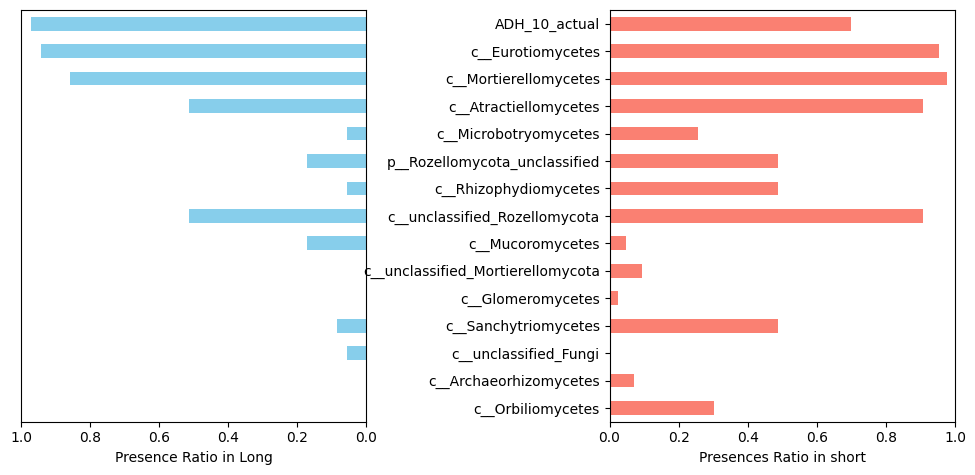

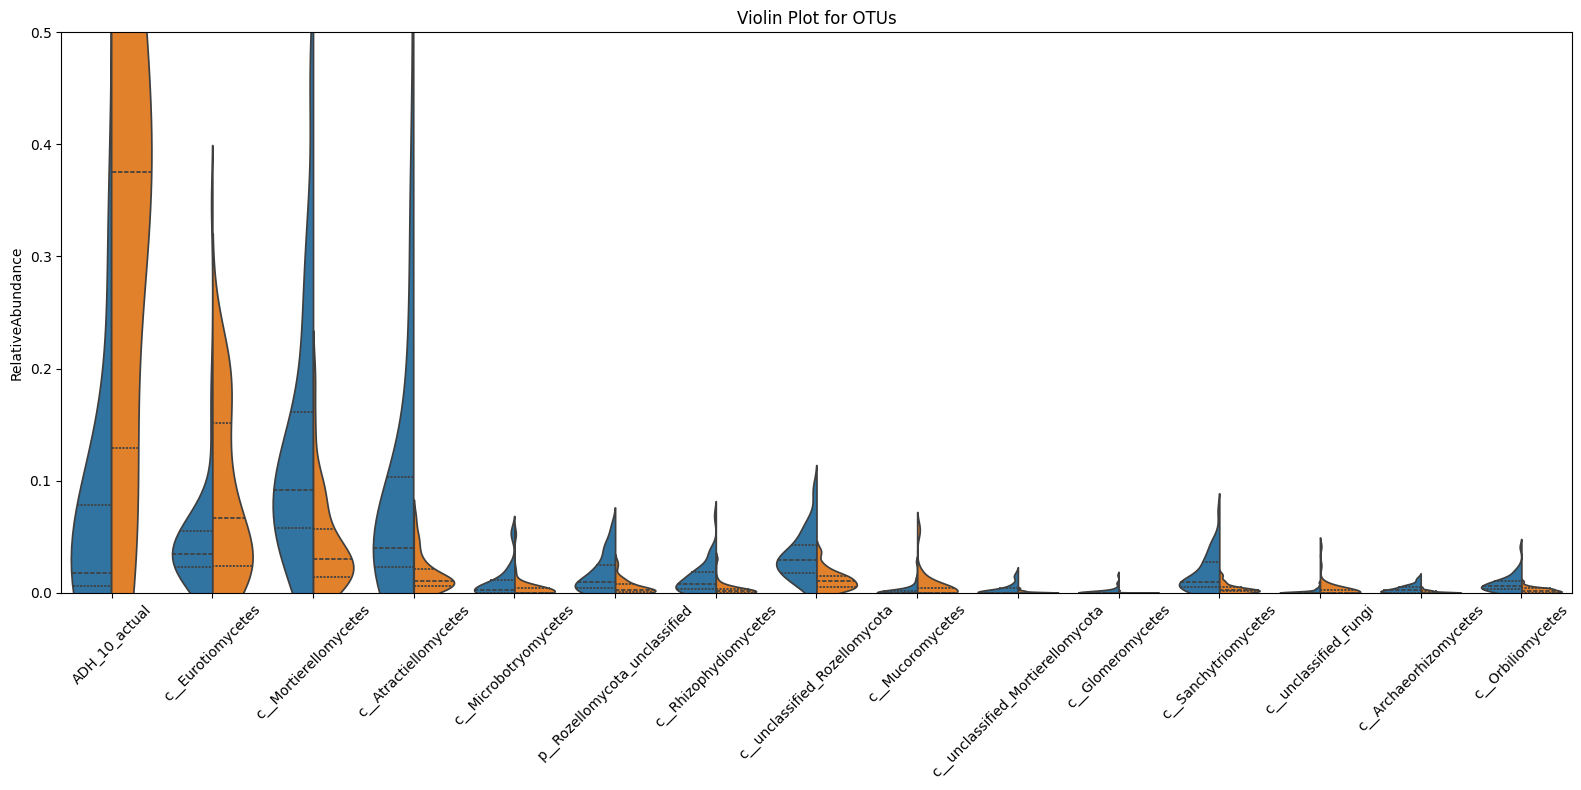

Fine tuned Lasso selected Index(['ADH_10_actual', 'o__Eurotiales', 'o__Mortierellales', 'o__Agaricales',
       'o__Leucosporidiales', 'o__Chaetosphaeriales', 'o__Pyxidiophorales',
       'o__Sanchytriales', 'o__unclassified_Fungi', 'o__Glomerales'],
      dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
                     OTU  presence_pos  presence_neg
0          ADH_10_actual      0.971429      0.697674
1          o__Eurotiales      0.942857      0.953488
2      o__Mortierellales      0.857143      0.976744
3          o__Agaricales      0.057143      0.488372
4    o__Leucosporidiales      0.200000      0.790698
5   o__Chaetosphaeriales      0.000000      0.093023
6     o__Pyxidiophorales      0.000000      0.069767
7       o__Sanchytriales      0.085714      0.488372
8  o__unclassified_Fungi      0.057143      0.000000
9          o__Glomerales      0.000000      0.302326


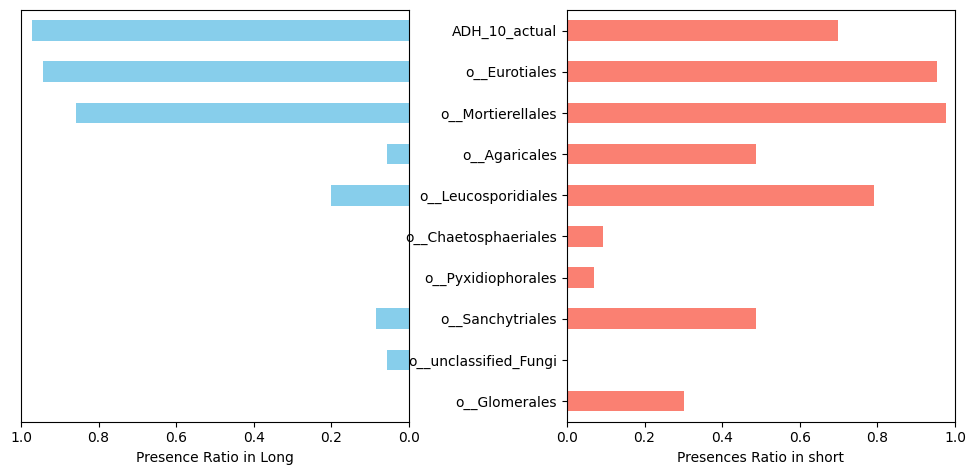

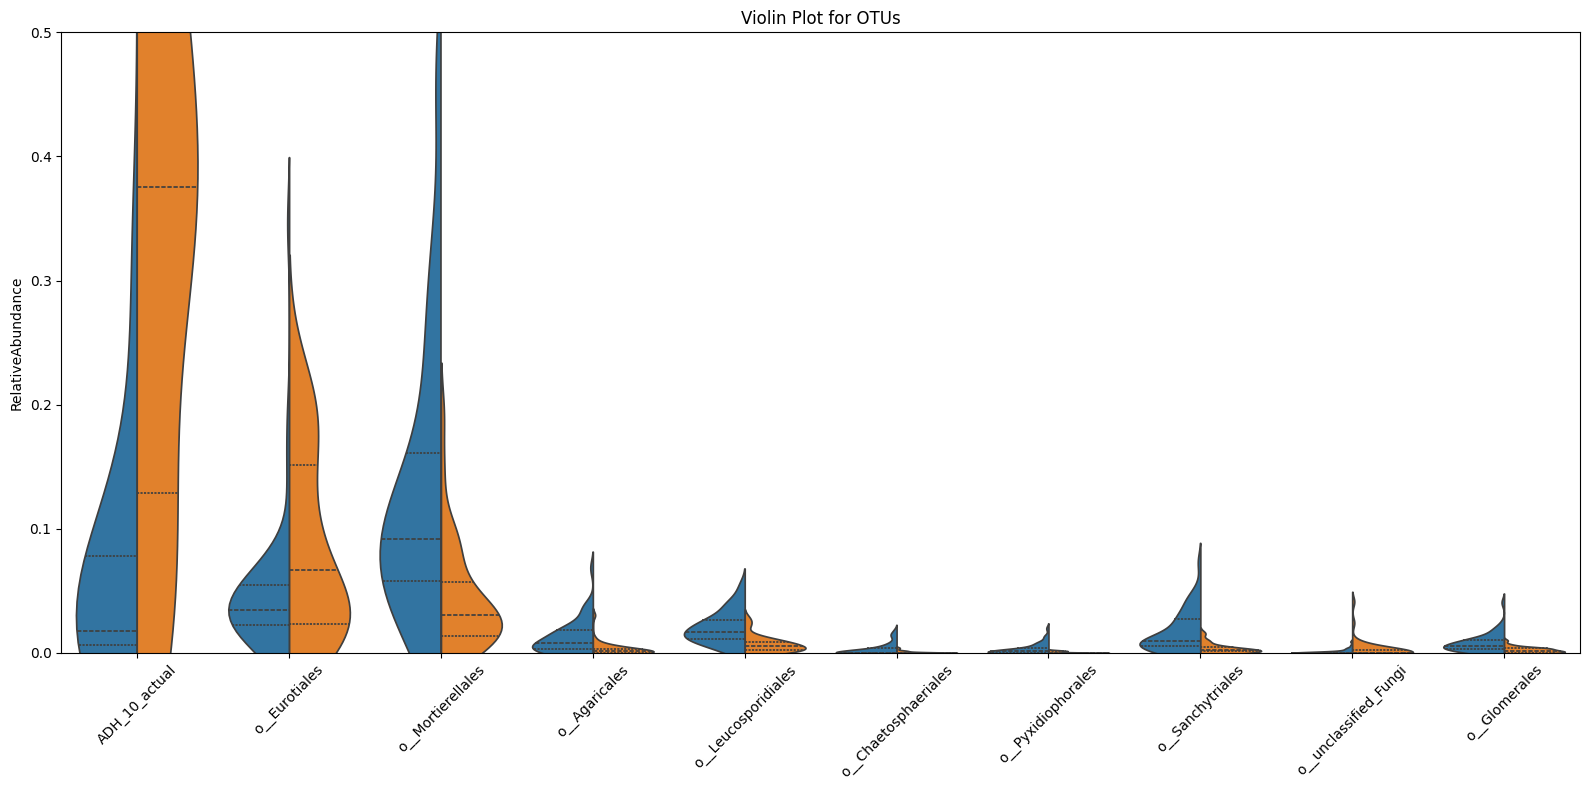

Fine tuned Lasso selected Index(['p__Ascomycota', 'p__Basidiomycota', 'k__Fungi_unclassified',
       'p__Rozellomycota', 'p__Monoblepharomycota'],
      dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
                     OTU  presence_pos  presence_neg
0          p__Ascomycota      1.000000      1.000000
1       p__Basidiomycota      0.942857      0.976744
2  k__Fungi_unclassified      0.371429      0.837209
3       p__Rozellomycota      0.114286      0.534884
4  p__Monoblepharomycota      0.085714      0.488372


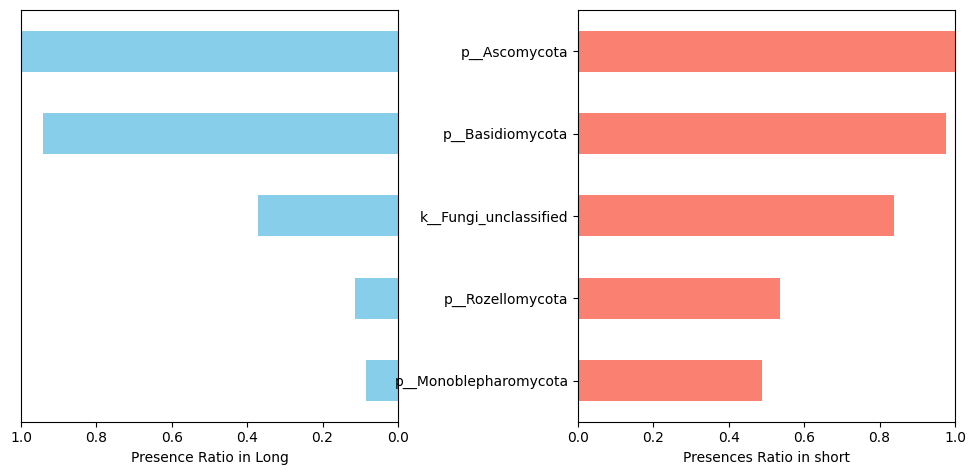

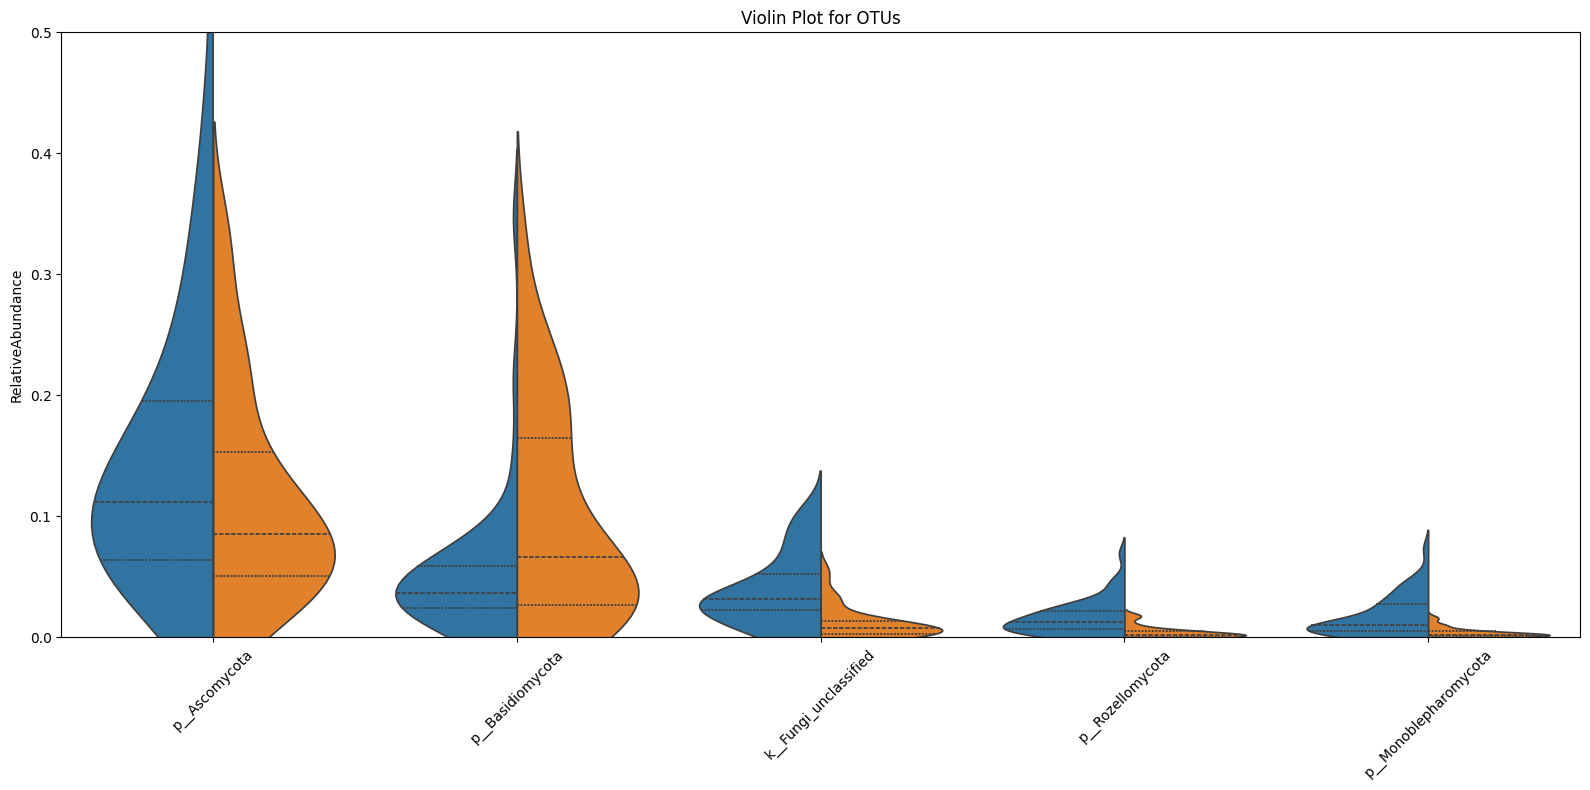

Fine tuned Lasso selected Index(['ITS00001', 'ITS00005', 'ITS00007', 'ITS00026', 'ITS00038', 'ITS00042',
       'ITS00049', 'ITS00130', 'ITS00138', 'ITS00149', 'ITS00150', 'ITS00184',
       'ITS00269', 'ITS00829'],
      dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
         OTU  presence_pos  presence_neg
0   ITS00001      0.857143      0.441860
1   ITS00005      0.485714      0.790698
2   ITS00007      0.657143      0.372093
3   ITS00026      0.171429      0.046512
4   ITS00038      0.000000      0.139535
5   ITS00042      0.085714      0.023256
6   ITS00049      0.000000      0.116279
7   ITS00130      0.028571      0.000000
8   ITS00138      0.000000      0.069767
9   ITS00149      0.000000      0.000000
10  ITS00150      0.057143      0.000000
11  ITS00184      0.000000      0.000000
12  ITS00269      0.000000      0.000000
13  ITS00829      0.000000      0.000000


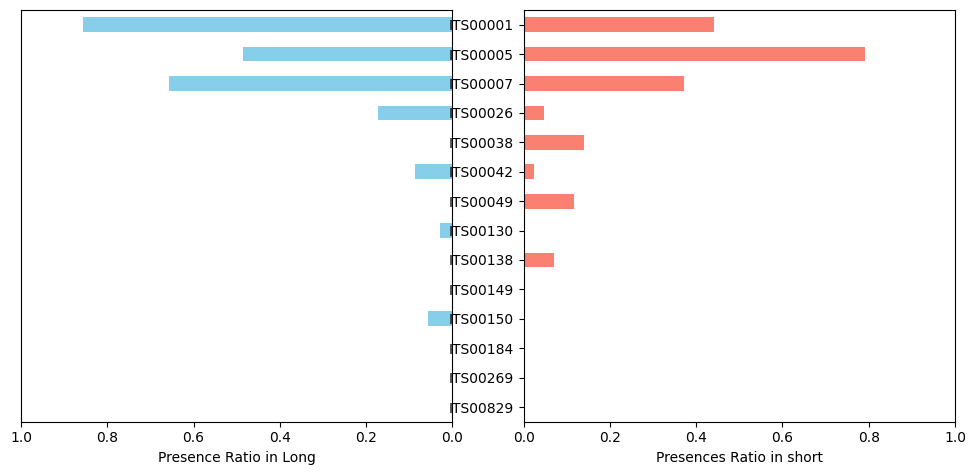

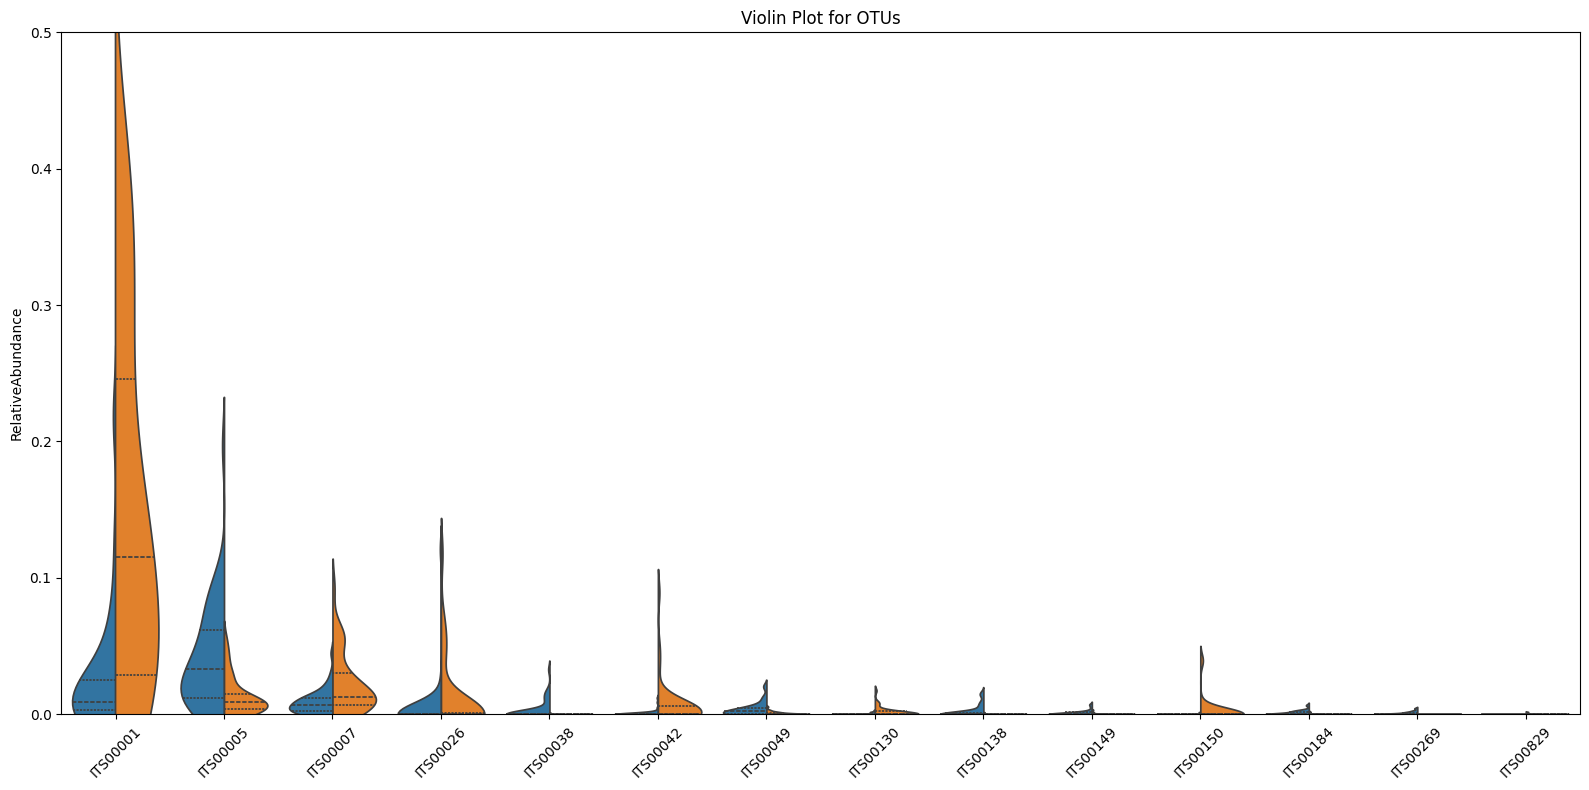

In [28]:
for i, data_FS in enumerate(X_lasso_ft_4taxa):
    selectedASVs_15=col_names_4taxa[i][xind_lasso_ft_4taxa[i]]
    print(f"Fine tuned Lasso selected {selectedASVs_15}")
    X_FS_15=data_4taxa[i][:,xind_lasso_ft_4taxa[i]]
    #df=pd.DataFrame(data=X_FS_15)
    FS.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs_15,posLabel="LONG",posText="Long",negText="short")
    FS.OTUviolin(X_FS_15,targetLabel,selectedASVs_15,y_max=0.5) 
    

FS_Fine tuned Lasso selected Index(['c__unclassified_Rozellomycota', 'ADH_10_actual',
       'c__Sanchytriomycetes', 'c__Atractiellomycetes',
       'c__Mortierellomycetes', 'c__Rozellomycotina_cls_Incertae_sedis',
       'c__Rhizophydiomycetes', 'c__Orbiliomycetes', 'c__Archaeorhizomycetes',
       'p__Rozellomycota_unclassified', 'c__unclassified_Mortierellomycota',
       'c__Glomeromycetes', 'c__Microbotryomycetes', 'c__Sordariomycetes',
       'c__Mucoromycetes', 'c__Eurotiomycetes'],
      dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
                                      OTU  presence_pos  presence_neg
0           c__unclassified_Rozellomycota      0.514286      0.906977
1                           ADH_10_actual      0.971429      0.697674
2                    c__Sanchytriomycetes      0.085714      0.488372
3                   c__Atractiellomycetes      0.514286      0.906977
4                   c__Mortierellomycetes      0.857143      0.976744

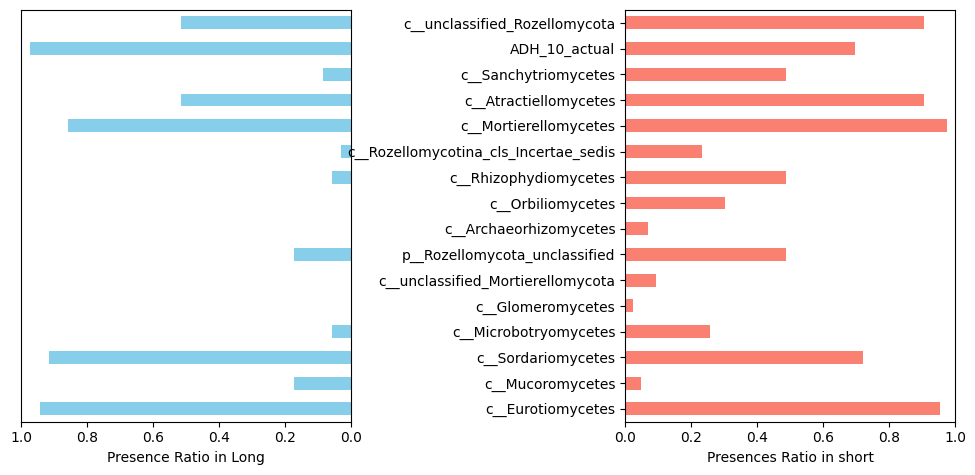

FS_Fine tuned Lasso selected Index(['o__Leucosporidiales', 'ADH_10_actual', 'o__Sanchytriales',
       'o__Mortierellales', 'o__Helotiales', 'o__Glomerales',
       'p__Mortierellomycota_unclassified', 'o__Pleosporales',
       'o__Tremellales', 'o__Ophiostomatales', 'o__Pyxidiophorales',
       'o__Atractiellales', 'o__Chaetosphaeriales', 'o__Onygenales',
       'p__Chytridiomycota_unclassified', 'o__Mucorales', 'o__Glomerellales',
       'o__Eurotiales'],
      dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
                                  OTU  presence_pos  presence_neg
0                 o__Leucosporidiales      0.200000      0.790698
1                       ADH_10_actual      0.971429      0.697674
2                    o__Sanchytriales      0.085714      0.488372
3                   o__Mortierellales      0.857143      0.976744
4                       o__Helotiales      0.028571      0.232558
5                       o__Glomerales      0.000000     

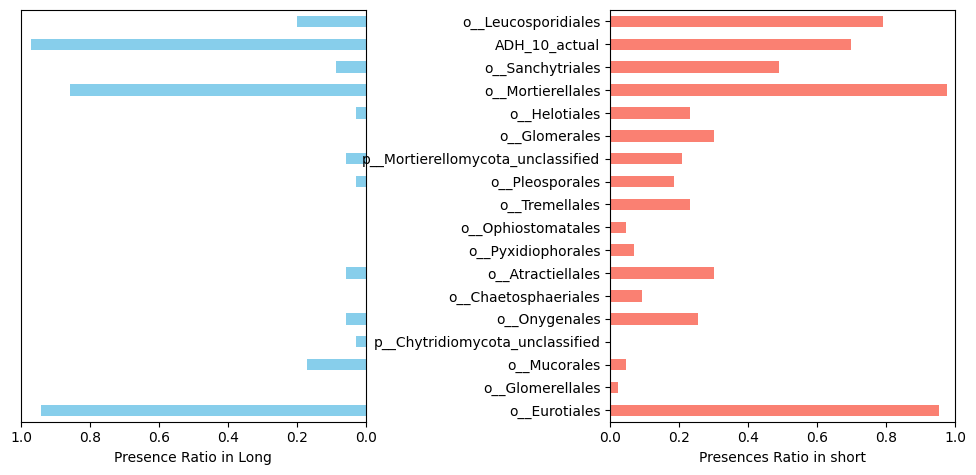

FS_Fine tuned Lasso selected Index(['p__Monoblepharomycota', 'p__Rozellomycota', 'k__Fungi_unclassified',
       'ADH_10_actual', 'p__Basidiomycota'],
      dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
                     OTU  presence_pos  presence_neg
0  p__Monoblepharomycota      0.085714      0.488372
1       p__Rozellomycota      0.114286      0.534884
2  k__Fungi_unclassified      0.371429      0.837209
3          ADH_10_actual      1.000000      1.000000
4       p__Basidiomycota      0.942857      0.976744


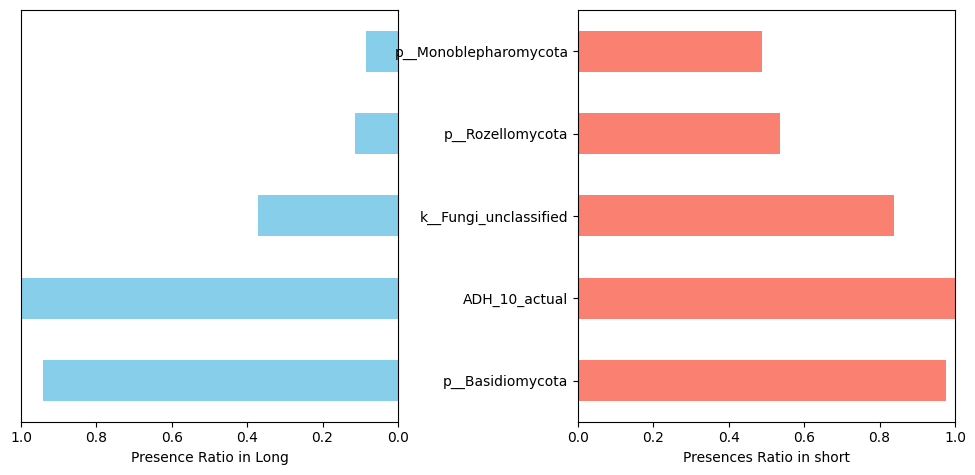

FS_Fine tuned Lasso selected Index(['ITS00001', 'ITS00005', 'ITS00269', 'ITS00049', 'ITS00007', 'ITS00184',
       'ITS00125', 'ITS00149', 'ITS00042', 'ITS00138', 'ITS00112', 'ITS00234',
       'ITS00217', 'ITS00130', 'ITS00038', 'ITS00229', 'ITS00300', 'ITS00091',
       'ITS00004', 'ITS00026', 'ITS00627', 'ITS00012', 'ITS00207', 'ITS00064',
       'ITS00355', 'ITS00505', 'ITS00561', 'ITS00829', 'ITS00265', 'ITS00003',
       'ITS00150', 'ITS00047', 'ITS00465', 'ITS00206', 'ITS00172'],
      dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
         OTU  presence_pos  presence_neg
0   ITS00001      0.857143      0.441860
1   ITS00005      0.485714      0.790698
2   ITS00269      0.000000      0.000000
3   ITS00049      0.000000      0.116279
4   ITS00007      0.657143      0.372093
5   ITS00184      0.000000      0.000000
6   ITS00125      0.000000      0.046512
7   ITS00149      0.000000      0.000000
8   ITS00042      0.085714      0.023256
9   ITS00138

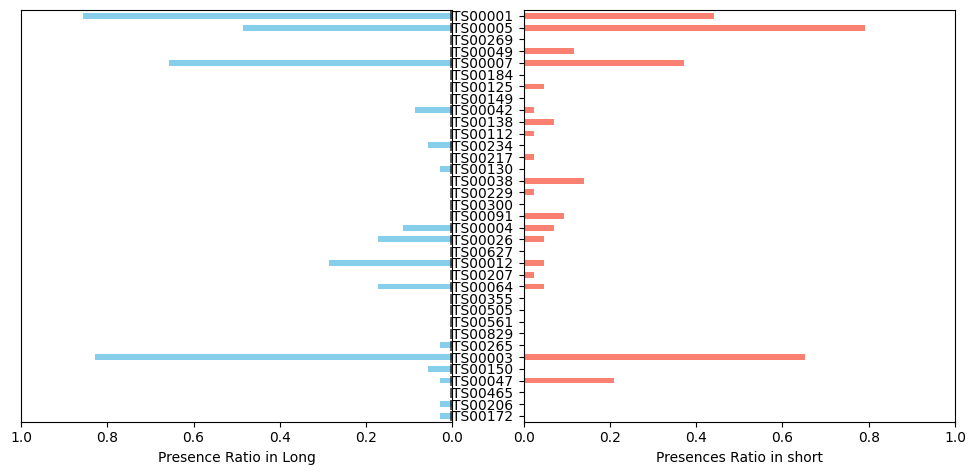

In [29]:
for i, data_FS in enumerate(X_FS_lassoft_4taxa):
    selectedASVs_15=col_names_4taxa[i][selectedOTU_index_FS_lassoft_4taxa[i]]
    print(f"FS_Fine tuned Lasso selected {selectedASVs_15}")
    X_FS_15=data_4taxa[i][:,selectedOTU_index_FS_lassoft_4taxa[i]]
    #df=pd.DataFrame(data=X_FS_15)
    FS.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs_15,posLabel="LONG",posText="Long",negText="short")
  